In [1]:
import src.mix as mix
import importlib
importlib.reload(mix)

<module 'src.mix' from '/home/daniel/Documents/programming/MIX/src/mix.py'>

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scprep
import sklearn
import tempfile
import os
import scanpy as sc
import phate
import meld

filepath = os.path.join("./data", "Klein2018_Zebrafish.h5ad")

In [9]:
URL = "https://ndownloader.figshare.com/files/25687247?private_link=f194ae7d6bcec9bd11a3"

scprep.io.download.download_url(URL, filepath)


In [6]:
adata = sc.read_h5ad(filepath)
subsample_index = np.random.choice(adata.shape[0], size=1000, replace=False)
adata = adata[subsample_index].copy()

Calculating PHATE...
  Running PHATE on 1000 observations and 29197 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.14 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.27 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 8.51 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 2.90 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.47 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.54 seconds.
Calculated PHATE in 15.46 seconds.


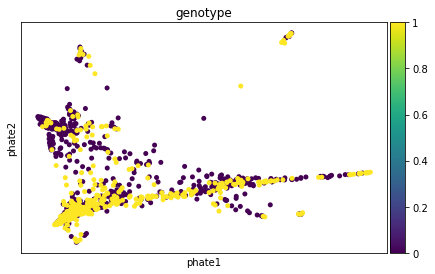

In [7]:
metadata = adata.obs
metadata['genotype'] = np.where(metadata['sample_labels'].str.startswith("chd"), 0, 1)
sc.pp.pca(adata, n_comps=50) 
sc.pp.neighbors(adata, n_neighbors= 10)

phate_op = phate.PHATE(n_components=2, knn=10, decay = 40, n_jobs = 8)
X_phate = phate_op.fit_transform(adata)
adata.obsm['X_phate'] = X_phate #housed in osbm because embedding

sc.pl.scatter(adata, basis = 'phate', color = 'genotype', size = 100)

In [ ]:
g = adata.obs["genotype"].copy()
gc = pd.Series(0, index=g.index, name=g.name)
gc

DEW194_AGTTGCGG_TGATGCCC_chdA    0
DEW191_AGGAGTCG_AAACTCGA_tyrA    0
DEW191_GCCTGGTA_TGATGCCC_tyrA    0
DEW191_ACGAATTC_AGACACCA_tyrA    0
DEW207_GTCCTTGC_TCCAGGGA_chdC    0
                                ..
DEW203_GGACTGGA_AGAGACTA_tyrC    0
DEW197_AAACAAAC_TTTAACAG_chdA    0
DEW201_GACTAGCG_CAGTCCCT_chdB    0
DEW208_CGGCTGTA_GACAACTT_chdC    0
DEW207_TCATTTCA_CTTAGGTA_chdC    0
Name: genotype, Length: 1000, dtype: int64

In [23]:
importlib.reload(mix)
mix.MIX(adata, diffusion_level=1, input_obs="genotype")

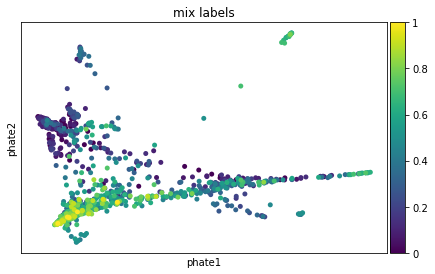

In [35]:
meld_op = meld.MELD(beta=67, knn=7)
sample_densities = meld_op.fit_transform(adata.obsm['X_pca'], sample_labels=metadata['genotype'])
adata.obs["meld_labels"] = sample_densities[0]

Building graph on 1000 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.27 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.42 seconds.


In [53]:
adata_meld = sample_densities.set_index(adata.obs['mix_labels'].index)
adata.obs["meld_labels"] = adata_meld[1]

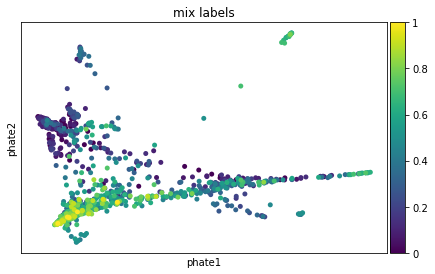

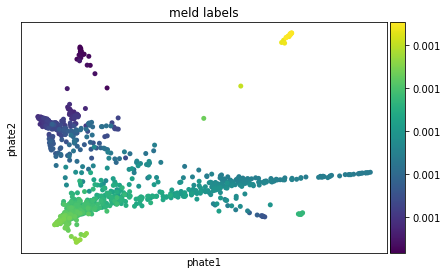

In [54]:
sc.pl.scatter(adata, basis = 'phate', color = 'mix_labels', size = 100)
sc.pl.scatter(adata, basis = 'phate', color='meld_labels', size = 100)